# Analysis of 124 morphological gene-KO CP-POSH dataset

#### The dataset consists of a selection of 124 genes targeting known morphology-modifying genes, along with nontargeting and intergenic controls.  The morphological data includes Hoechst, Concavalin A, WGA, Phalloidin, and Mitoprobe.


In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook uses PCA transformed normalized cellstats features (shared in this s3 location: s3://insitro-research-2023-cellpaint-posh/normalized_embeddings/) as input.
For custom feature dataframes, the script for Normalizing and Aggregating Embeddings per sgRNA KO can be found here.

In [12]:
import pandas as pd
from cp_posh.utils import data
from cp_posh.analysis import aggregate, similarity, plotting, stringdb, metrics

In [37]:
# copy datasets from s3
# !aws s3 sync s3://insitro-research-2023-cellpaint-posh/ ./datasets/

In [ ]:
# load normalized cellstats features
normalized_cellstats_features = pd.read_parquet("./datasets/normalized_embeddings/cellstats_features_morphology_124.pq")
# load sgRNA aggregated normalized cellstats features
sgRNA_aggregate_cellstats_features = pd.read_parquet("./datasets/aggregate_sgRNA_embeddings/cellstats_features_morphology_124.pq")
# compute gene aggregated
gene_aggregate_cellstats_features = aggregate.aggregate_embeddings_by_gene(embeddings = sgRNA_aggregate_cellstats_features, method = "median")

## Measuring the similarities of gRNAs targeting the same genes
#### gRNA similarities can be shown either as boxplots or as scatterplots showing the distributions of individual gRNAs for each gene

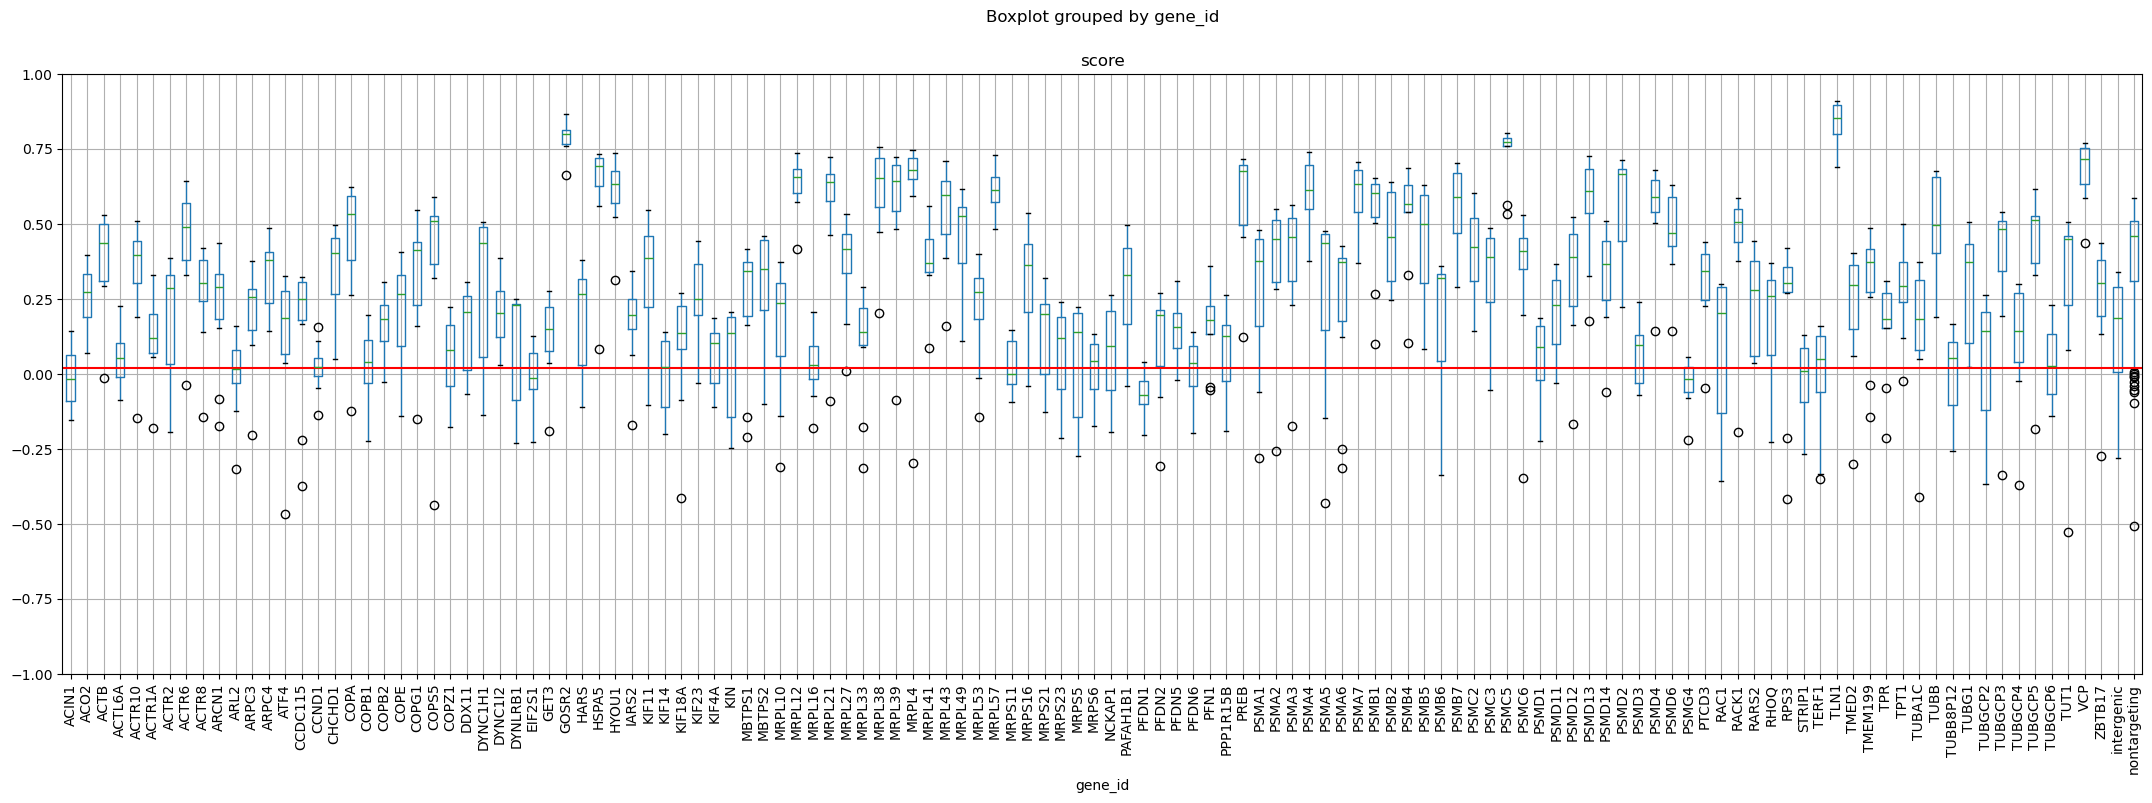

In [83]:
gRNAscores = similarity.get_gRNA_scores(sgRNA_aggregate_cellstats_features)
gRNAscores['score'] = gRNAscores['score'].apply(pd.to_numeric)

## Comparison to string-db database as a "ground-truth" comparison of network quality

In [34]:
cosine_similarity = similarity.get_embedding_cosine_similarity(gene_aggregate_cellstats_features)

Using genes from correlation matrix, pulling stringdb network...


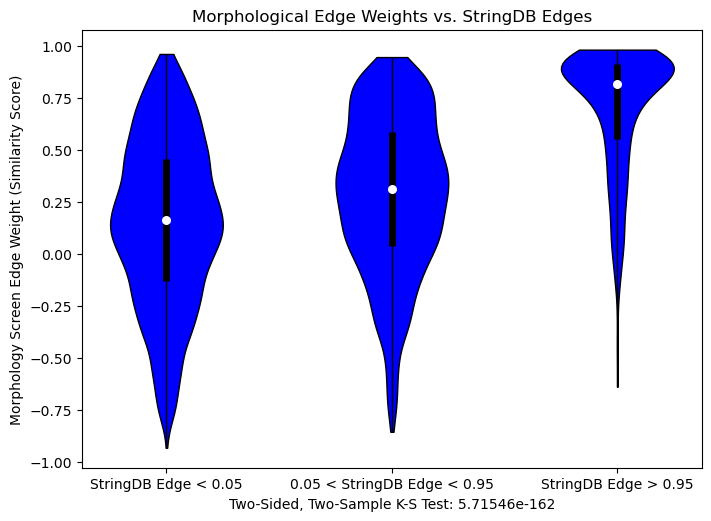

Statistics of high-weight edges vs. unmatched edges:
KstestResult(statistic=0.5839400262829437, pvalue=5.715456195218404e-162, statistic_location=0.6161815195797019, statistic_sign=-1)
Statistics of mid-weight edges vs. unmatched edges:
KstestResult(statistic=0.15074419938806732, pvalue=5.886765125841568e-28, statistic_location=0.223731251918873, statistic_sign=-1)
Statistics of high-weight edges vs. mid-weight edges:
KstestResult(statistic=0.5024912978932886, pvalue=1.6190439025176717e-101, statistic_location=0.6560103271985707, statistic_sign=-1)
Number of unmatched edges, based on stringDB thresholding: 4736
Number of mid-weight edges, based on stringDB thresholding: 1961
Number of high-weight edges, based on stringDB thresholding: 563


(KstestResult(statistic=0.5839400262829437, pvalue=5.715456195218404e-162, statistic_location=0.6161815195797019, statistic_sign=-1),
 KstestResult(statistic=0.15074419938806732, pvalue=5.886765125841568e-28, statistic_location=0.223731251918873, statistic_sign=-1),
 KstestResult(statistic=0.5024912978932886, pvalue=1.6190439025176717e-101, statistic_location=0.6560103271985707, statistic_sign=-1))

In [85]:
plotting.plot_stringdb_violin(gene_similarity = cosine_similarity, stringdb_threshold_lower = 0.05, stringdb_threshold_upper = 0.95)

## Determine the AUCROC of the morphology-determined network compared to the StringDB Network

In [134]:
stringdb_matrix = stringdb.get_stringdb_data(gene_aggregate_cellstats_features.index.values, physical_db=False)
roc_prc_metrics = metrics.compute_stringdb_roc_prc_metrics(gene_aggregate_cellstats_features, select_genes=gene_aggregate_cellstats_features.index.values, stringdb_matrix=stringdb_matrix, stringdb_threshold=0.95, abs_value=True)

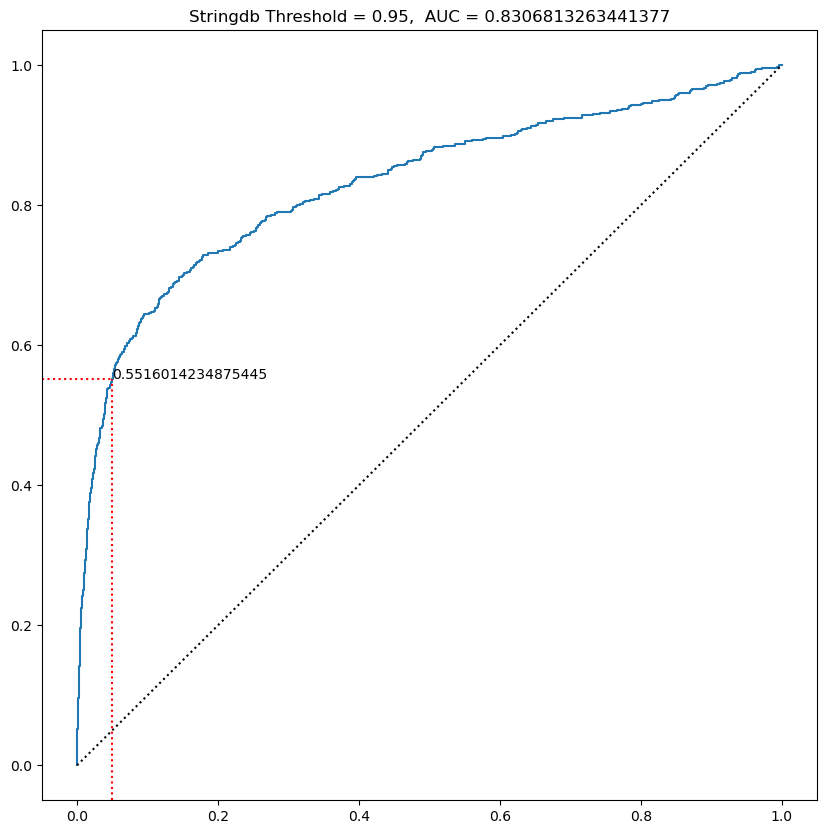

In [138]:
plotting.plot_roc_curve(roc_prc_metrics, stringdb_threshold=0.95)

## Plotting Volcano Plots for Features and Genes of Interest

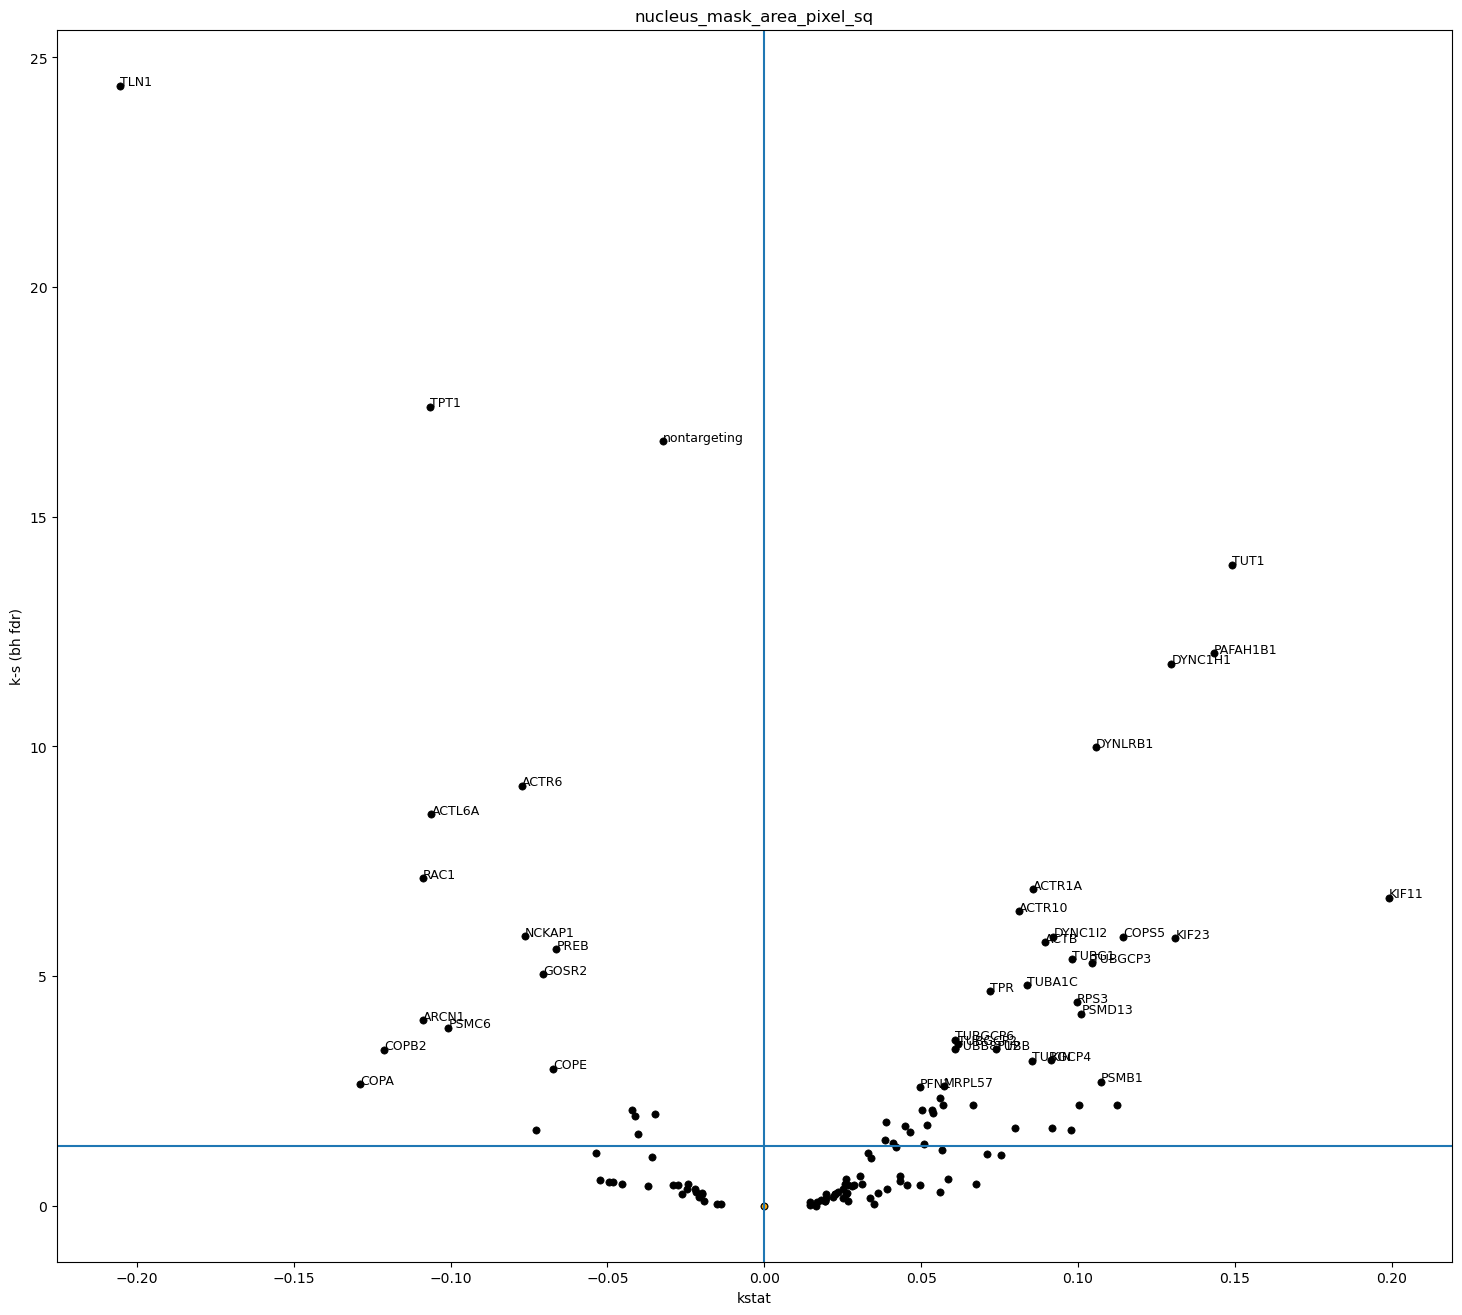

In [112]:
plotting.plot_gene_volcano(feature_pd = normalized_cellstats_features,
                           plot_feature = 'nucleus_mask_area_pixel_sq',
                           control_gene='intergenic',
                           volcano_label_threshold = 2.5,
                           xaxis = 'kstat',
                           control_dot = 'intergenic',)

Running 2-sample KS tests on all features between target and control gene...


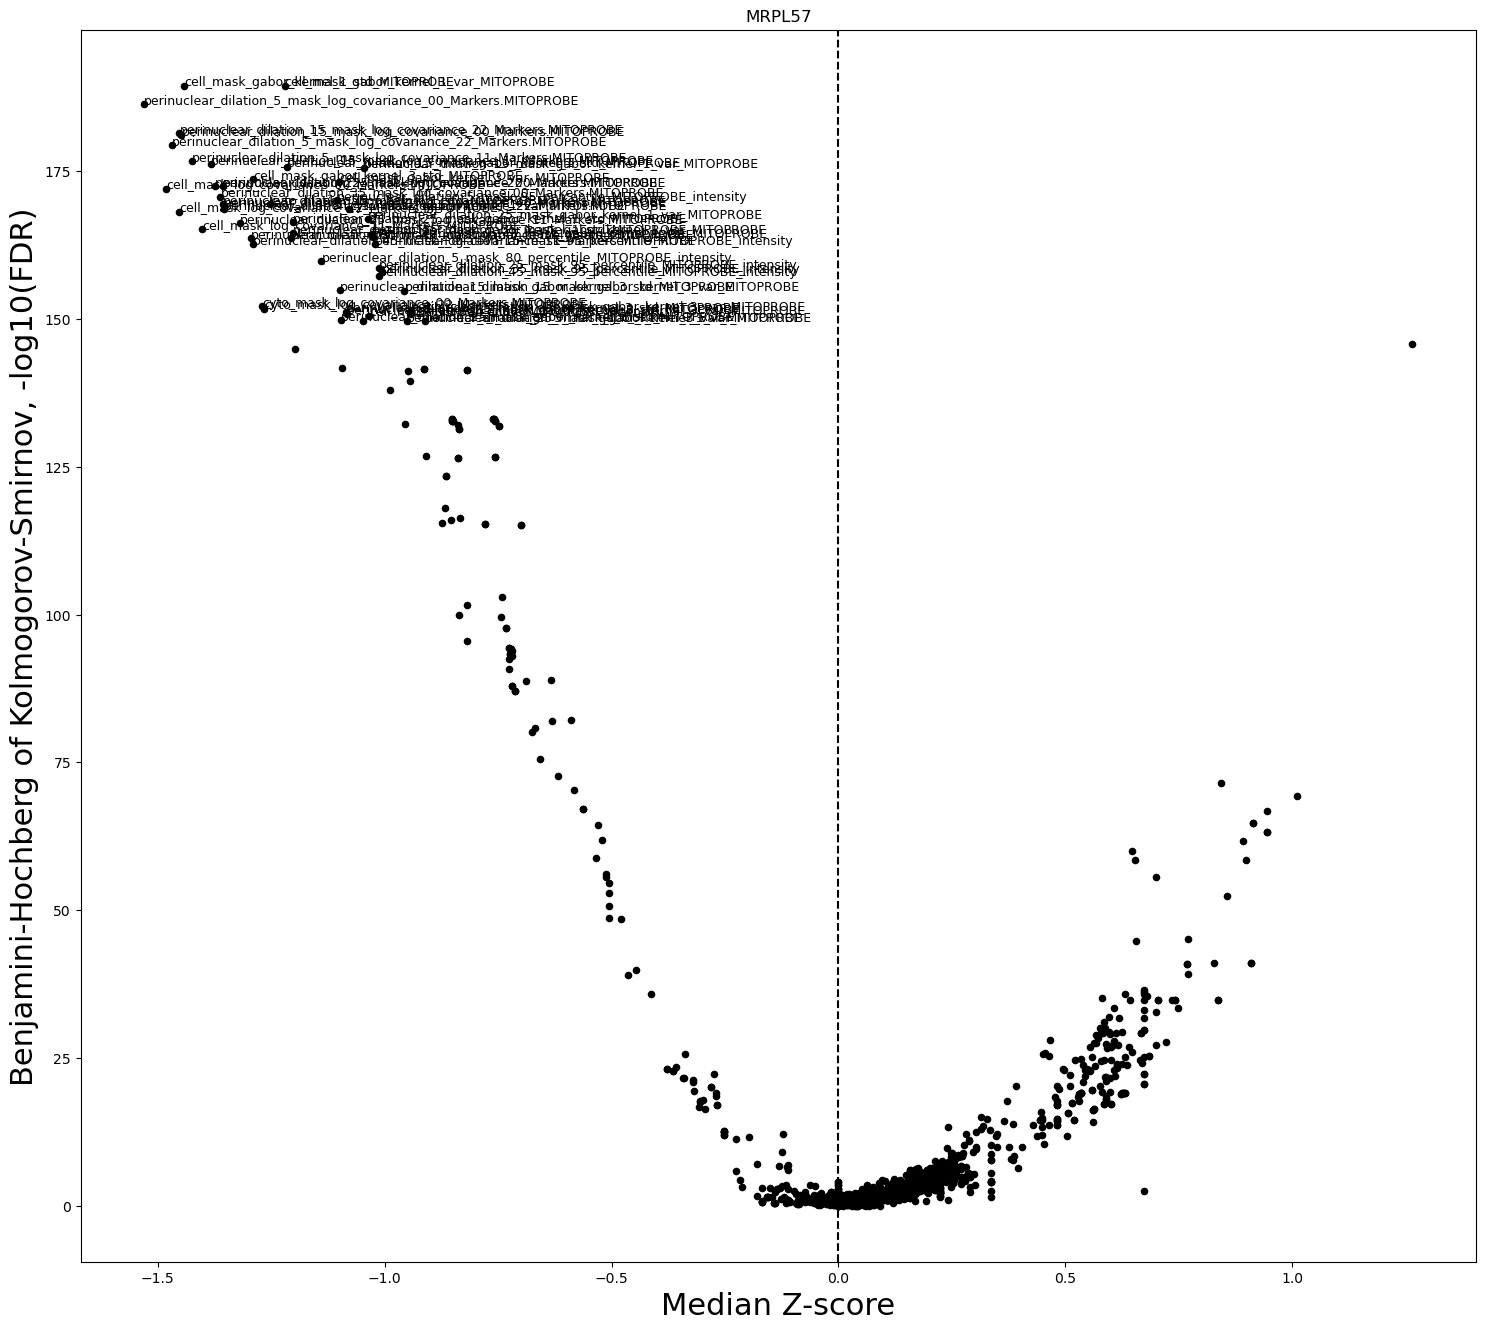

In [115]:
plotting.plot_feature_volcano(feature_pd = normalized_cellstats_features, plot_gene = 'MRPL57', control_gene = 'intergenic',  volcano_label_threshold = 50, xaxis = 'z')

Running 2-sample KS tests on all features between target and control gene...


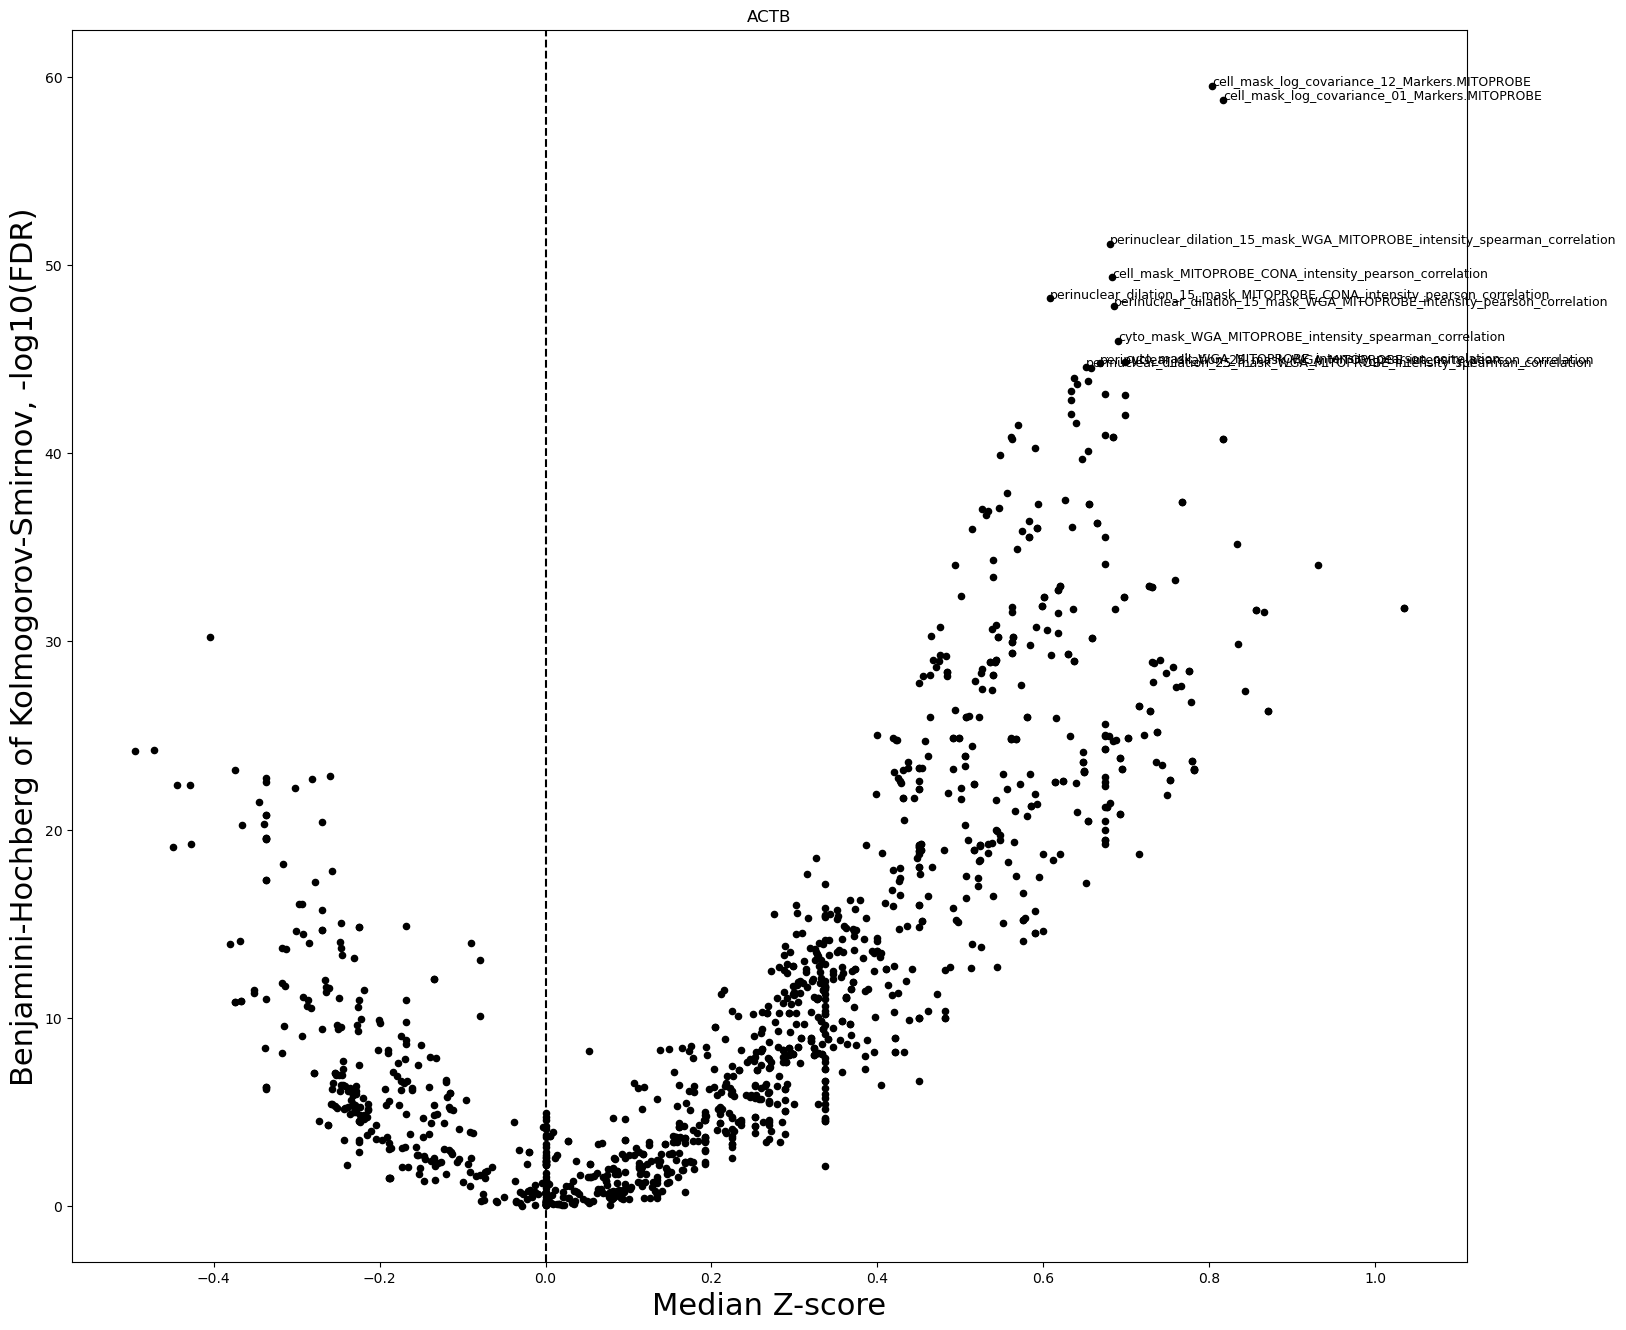

In [116]:
plotting.plot_feature_volcano(feature_pd = normalized_cellstats_features, plot_gene = 'ACTB', control_gene = 'intergenic',  volcano_label_threshold = 10)

Running 2-sample KS tests on all features between target and control gene...


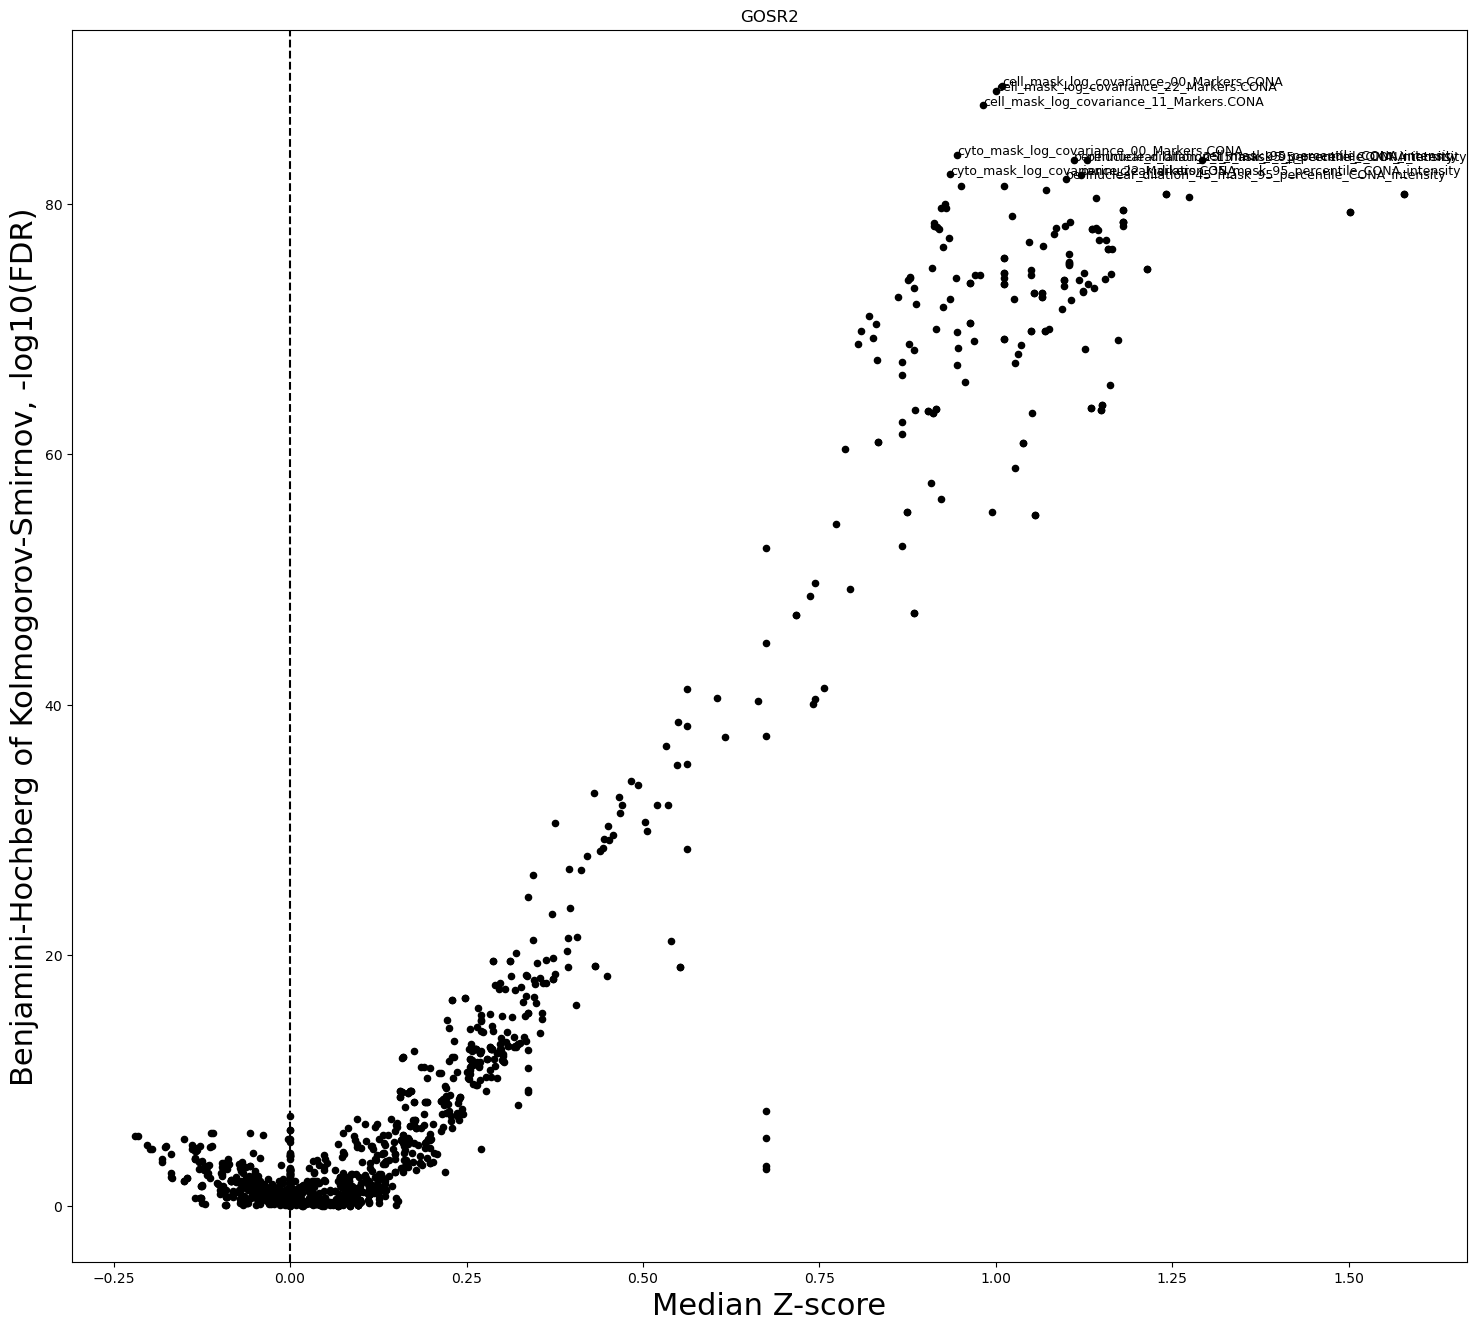

In [117]:

plotting.plot_feature_volcano(feature_pd = normalized_cellstats_features, plot_gene = 'GOSR2', control_gene = 'intergenic',  volcano_label_threshold = 10)

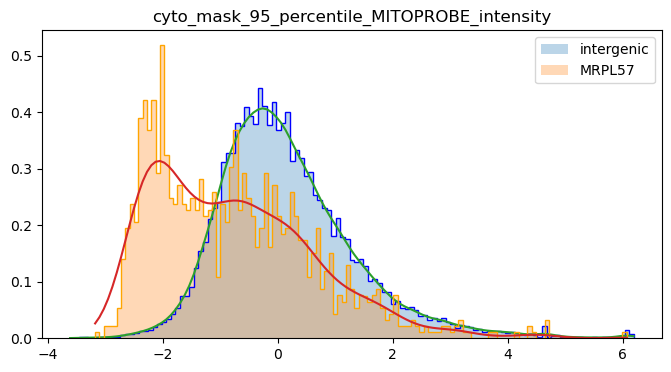

In [119]:
plotting.plot_feature_histo(feature_pd = normalized_cellstats_features,feature = 'cyto_mask_95_percentile_MITOPROBE_intensity',test_gene='MRPL57',control_gene='intergenic',bins=123)


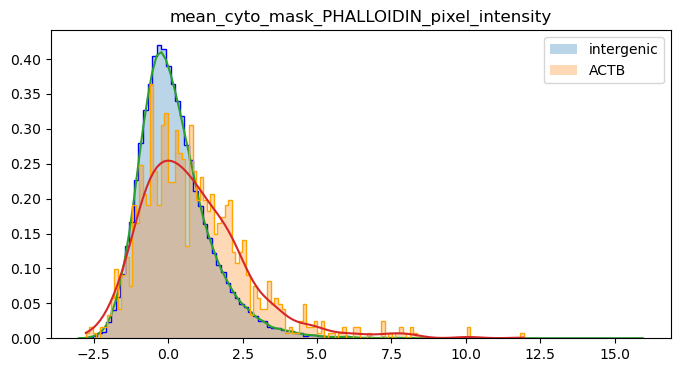

In [121]:
plotting.plot_feature_histo(feature_pd = normalized_cellstats_features,feature = 'mean_cyto_mask_PHALLOIDIN_pixel_intensity',test_gene='ACTB',control_gene='intergenic',bins=123)


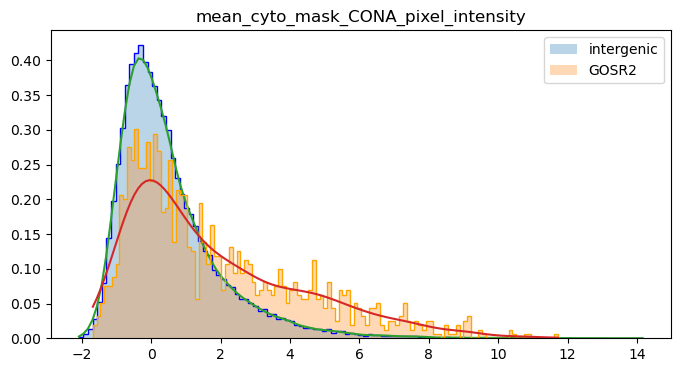

In [122]:
plotting.plot_feature_histo(feature_pd = normalized_cellstats_features,feature = 'mean_cyto_mask_CONA_pixel_intensity',test_gene='GOSR2',control_gene='intergenic',bins=123)


## Plot a UMAP of Normalized CellStats features at the gene level

In [130]:
colours = {"proteasome": "tomato",
           "unfolded protein response": "darkslateblue",
           "actin / kinesin": "darkred",
           "other" : "lightgreen",
           "Golgi-ER retrograde" : "tan",
           "microtubule / dynein" : "cyan",
           "mitochondrial translation" : "teal",
           "intergenic" : "gray",
           "nontargeting" : "gray"}

go_map = {'PSMA6': 'proteasome', 'PSMA3': 'proteasome', 'EIF2S1': 'unfolded protein response', 'PSMA1': 'proteasome', 'PSMD14': 'proteasome', 'KIF11': 'actin / kinesin', 'RACK1': 'other', 'PAFAH1B1': 'microtubule / dynein', 'COPB1': 'Golgi-ER retrograde', 'PSMB6': 'proteasome', 'VCP': 'other', 'DYNLRB1': 'microtubule / dynein', 'PSMB4': 'proteasome', 'PSMA5': 'proteasome', 'PSMA2': 'proteasome', 'PFDN2': 'actin / kinesin', 'COPA': 'Golgi-ER retrograde', 'COPB2': 'Golgi-ER retrograde', 'TUBB': 'microtubule / dynein', 'PSMB5': 'proteasome', 'PSMD6': 'proteasome', 'PSMA7': 'proteasome', 'PSMG4': 'proteasome', 'TUBGCP2': 'microtubule / dynein', 'ARL2': 'microtubule / dynein', 'COPG1': 'Golgi-ER retrograde', 'PSMD4': 'proteasome', 'PSMA4': 'proteasome', 'PSMD3': 'proteasome', 'DYNC1H1': 'microtubule / dynein', 'ACTL6A': 'actin / kinesin', 'COPS5': 'unfolded protein response', 'RPS3': 'microtubule / dynein', 'PSMC3': 'proteasome', 'PSMC5': 'proteasome', 'HYOU1': 'unfolded protein response', 'TUT1': 'other', 'HSPA5': 'unfolded protein response', 'DYNC1I2': 'microtubule / dynein', 'KIF23': 'actin / kinesin', 'PSMB2': 'proteasome', 'PSMD13': 'proteasome', 'HARS': 'mitochondrial translation', 'TUBG1': 'microtubule / dynein', 'KIF18A': 'actin / kinesin', 'PFDN6': 'actin / kinesin', 'ARCN1': 'Golgi-ER retrograde', 'MRPL21': 'mitochondrial translation', 'ACTR2': 'actin / kinesin', 'PSMC6': 'proteasome', 'PSMD1': 'proteasome', 'KIN': 'other', 'IARS2': 'mitochondrial translation', 'COPZ1': 'Golgi-ER retrograde', 'COPE': 'Golgi-ER retrograde', 'PSMD11': 'proteasome', 'CCDC115': 'Golgi-ER retrograde', 'MRPL33': 'mitochondrial translation', 'TUBGCP5': 'microtubule / dynein', 'PSMD2': 'proteasome', 'PSMC2': 'proteasome', 'ACTR6': 'actin / kinesin', 'TPR': 'microtubule / dynein', 'CCND1': 'other', 'ACTR8': 'actin / kinesin', 'MRPL57': 'mitochondrial translation', 'TUBGCP4': 'microtubule / dynein', 'MRPL10': 'mitochondrial translation', 'TUBGCP3': 'microtubule / dynein', 'ACTR1A': 'actin / kinesin', 'MRPS21': 'mitochondrial translation', 'MRPS23': 'mitochondrial translation', 'PSMD12': 'proteasome', 'DDX11': 'unfolded protein response', 'PFDN1': 'actin / kinesin', 'MRPL4': 'mitochondrial translation', 'TLN1': 'actin / kinesin', 'TMEM199': 'Golgi-ER retrograde', 'PFN1': 'actin / kinesin', 'MRPL43': 'mitochondrial translation', 'GOSR2': 'Golgi-ER retrograde', 'ACTR10': 'actin / kinesin', 'MRPS11': 'mitochondrial translation', 'CHCHD1': 'mitochondrial translation', 'PSMB7': 'proteasome', 'PSMB1': 'proteasome', 'TPT1': 'microtubule / dynein', 'PPP1R15B': 'unfolded protein response', 'MBTPS2': 'unfolded protein response', 'MRPL53': 'mitochondrial translation', 'MRPL49': 'mitochondrial translation', 'GET3': 'Golgi-ER retrograde', 'PREB': 'Golgi-ER retrograde', 'TUBB8P12': 'microtubule / dynein', 'MRPL27': 'mitochondrial translation', 'MRPL39': 'mitochondrial translation', 'MRPL12': 'mitochondrial translation', 'RARS2': 'mitochondrial translation', 'ATF4': 'unfolded protein response', 'TMED2': 'Golgi-ER retrograde', 'PTCD3': 'mitochondrial translation', 'ACIN1': 'other', 'TUBA1C': 'microtubule / dynein', 'MRPL16': 'mitochondrial translation', 'MRPS6': 'mitochondrial translation', 'MRPS16': 'mitochondrial translation', 'MRPL38': 'mitochondrial translation', 'MRPS5': 'mitochondrial translation', 'TUBGCP6': 'microtubule / dynein', 'MRPL41': 'mitochondrial translation', 'ARPC4': 'actin / kinesin', 'MBTPS1': 'unfolded protein response', 'ACTB': 'actin / kinesin', 'KIF4A': 'actin / kinesin', 'TERF1': 'microtubule / dynein', 'ZBTB17': 'unfolded protein response', 'RAC1': 'microtubule / dynein', 'PFDN5': 'actin / kinesin', 'ARPC3': 'actin / kinesin', 'RHOQ': 'actin / kinesin', 'NCKAP1': 'actin / kinesin', 'KIF14': 'actin / kinesin', 'ACO2': 'other', 'STRIP1': 'actin / kinesin', 'intergenic': 'intergenic', 'nontargeting': 'nontargeting'}
go_map_colours = go_map.copy()
for k in go_map_colours:
    go_map_colours[k] = colours[go_map_colours[k]]

/home/ubuntu/miniconda3/envs/insitro/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/ubuntu/software/cp-posh/cp_posh/analysis/plotting.py:270: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  np.array(df.x.values),


adjust_text = TRUE, may slow down UMAP plotting time...


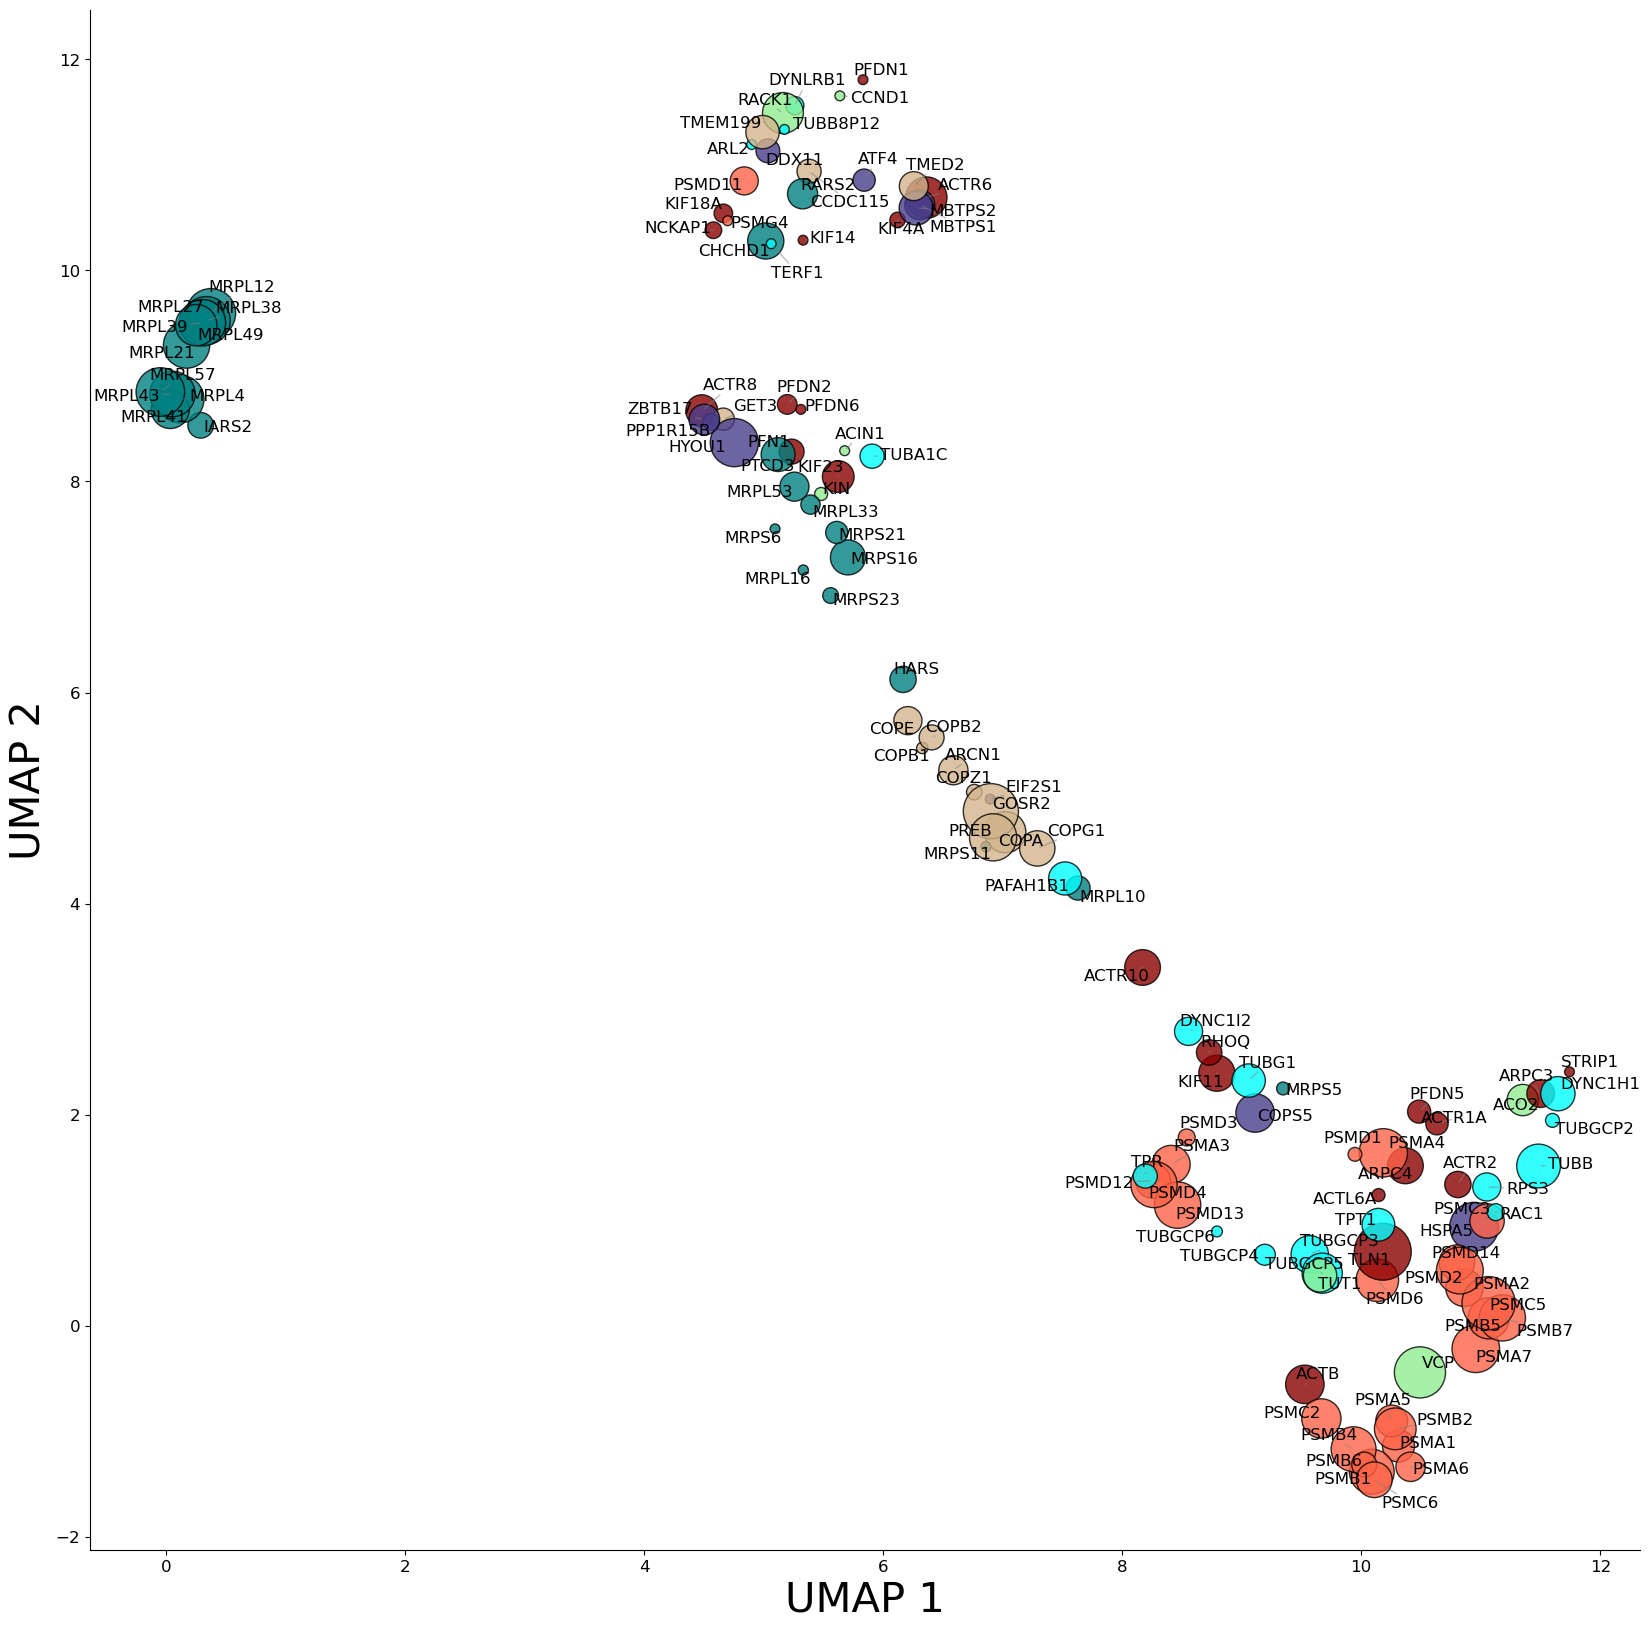

UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=5, random_state=1, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
gRNAscores_simple = pd.DataFrame(index = gRNAscores.index.get_level_values('gene_id'), data={'score':gRNAscores.score.values})
gRNAscores_simple = gRNAscores_simple.groupby('gene_id').mean()

select_genes = list(gene_aggregate_cellstats_features.index.values)
select_genes.remove('intergenic')
select_genes.remove('nontargeting')
gRNAscores_simple.drop(index=['intergenic','nontargeting'])

plotting.compute_plot_umap(gene_embeddings = gene_aggregate_cellstats_features,
                            selected_genes = select_genes,
                            within_gene_gRNA_similarity_scores = gRNAscores_simple,
                            neighbors = 5, #5
                            leiden_resolution = 1, #1
                            max_community_size = 50, #50
                            adjust_texts = True,
                            clusters = go_map_colours,
                            dot_size_min = 50,
                            dot_size_max = 2000,
                            font_size = 12,
                            random_state=1
                            )

